# PLAN




    * Steps 1-10

    Summary of what we have done so far. Just check the headers to see if you missed  anything.

    * Step 11 
    
    Cross validation with the training data.
    
    * Step 12 

    Testing the model on test data.
    
    * Step 13

    Extending the prediction to the future.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.tsa.ar_model import ar_select_order

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Step 1 - Load the Data

In [3]:
flights = pd.read_csv('data/flights_train.csv', index_col=0, parse_dates=True)
flights.head()

,passengers
date,
1949-01-01,64
1949-02-01,75
1949-03-01,98
1949-04-01,93
1949-05-01,80


In [4]:
# Inspect the size of the data
flights.shape # 11 years of monthly data

(132, 1)

In [5]:
flights

,passengers
date,
1949-01-01,64
1949-02-01,75
1949-03-01,98
1949-04-01,93
1949-05-01,80
...,...
1959-08-01,430
1959-09-01,383
1959-10-01,351


# Plot the data

In [6]:
def plot_flights(df, title='Monthly Passenger Numbers in 1000 over Time', ylim=True):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('# of Passengers in 1000')
    if ylim:
        plt.ylim(ymin=0)
    plt.show()

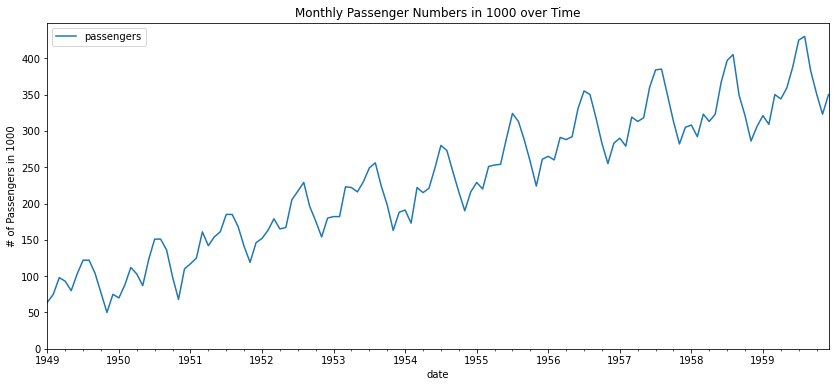

In [7]:
plot_flights(flights)

In [8]:
flights

,passengers
date,
1949-01-01,64
1949-02-01,75
1949-03-01,98
1949-04-01,93
1949-05-01,80
...,...
1959-08-01,430
1959-09-01,383
1959-10-01,351


# Step 2 - Clean the Data

Fortunately we do not have to do that in case of the flights data. The steps for this for the temperature data are summarised in the AR notebook.

# Step 3 - Extract the Timestep and the Seasonal Dummies for the whole Dataset

In [9]:
# Create a timestep variable
flights['timestep'] = list(range(len(flights)))
flights

,passengers,timestep
date,,
1949-01-01,64,0
1949-02-01,75,1
1949-03-01,98,2
1949-04-01,93,3
1949-05-01,80,4
...,...,...
1959-08-01,430,127
1959-09-01,383,128
1959-10-01,351,129


In [10]:
# Create the seasonal dummies
seasonal_dummies = pd.get_dummies(flights.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(flights.index)

flights = flights.join(seasonal_dummies)
flights.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1949-01-01,64,0,0,0,0,0,0,0,0,0,0,0,0
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0


# 4) Train-Test-Split

Fortunately not necessary for the flights data.

# 5) Model the Trend_Seasonal model

In [11]:
# Define X and y
X = flights.drop(columns=['passengers'])
y = flights['passengers']

In [12]:
y

date
1949-01-01     64
1949-02-01     75
1949-03-01     98
1949-04-01     93
1949-05-01     80
             ... 
1959-08-01    430
1959-09-01    383
1959-10-01    351
1959-11-01    323
1959-12-01    350
Name: passengers, Length: 132, dtype: int64

In [13]:
# Create and fit the model
m = LinearRegression()
m.fit(X, y)

LinearRegression()

In [14]:
# Create a new column with the predictions of the trend_seasonal model
flights['trend_seasonal'] = m.predict(X)
flights.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
date,,,,,,,,,,,,,,
1949-01-01,64,0,0,0,0,0,0,0,0,0,0,0,0,59.594697
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061


# Plot the original data and preliminary model

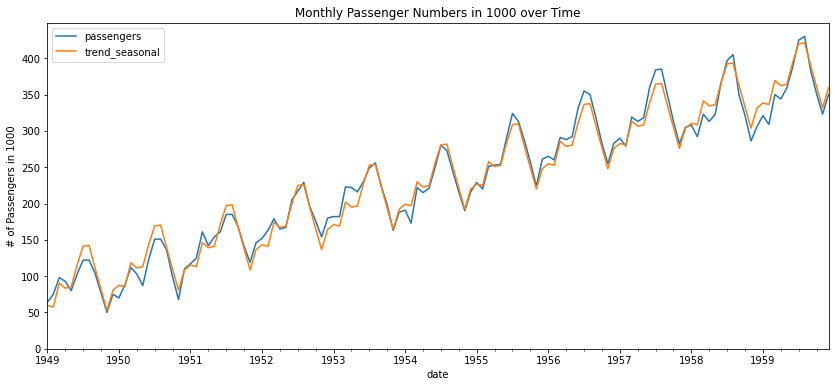

In [15]:
plot_flights(flights[['passengers', 'trend_seasonal']])

# 6) - Extract the remainder

In [16]:
# We want to extract the part of the model that the trend_seasonal is not able to explain
flights['remainder'] = flights['passengers'] - flights['trend_seasonal']

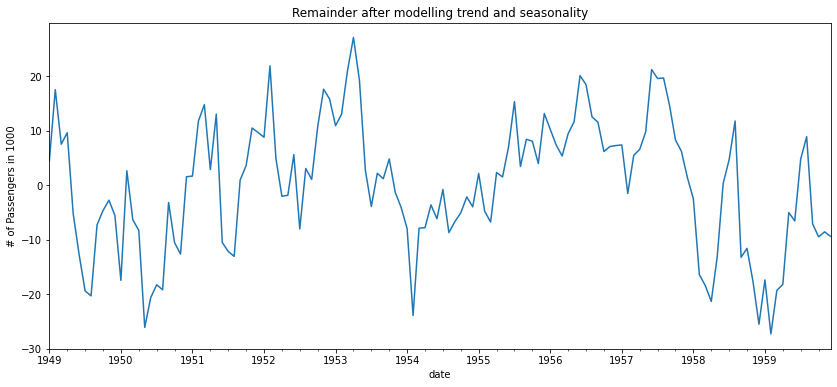

In [17]:
plot_flights(flights['remainder'], 
             title='Remainder after modelling trend and seasonality', 
             ylim=False)

In [18]:
flights["remainder"].std(), flights["passengers"].std()

(11.870004641031825, 93.90204210479334)

# 7) - Inspect the remainder to decide how many lags to include


In [19]:
selected_order = ar_select_order(flights['remainder'], maxlag = 12)
selected_order.ar_lags

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


[1]

# 8) - Add the lags of the remainder to the training data

In [20]:
flights['lag1'] = flights['remainder'].shift(1)
flights.dropna(inplace=True)
flights.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
date,,,,,,,,,,,,,,,,
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788,17.496212,4.405303
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788,7.496212,17.496212
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879,9.587121,7.496212
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061,-5.231061,9.587121
1949-06-01,103,5,0,0,0,0,1,0,0,0,0,0,0,115.776515,-12.776515,-5.231061


In [21]:
flights

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
date,,,,,,,,,,,,,,,,
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788,17.496212,4.405303
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788,7.496212,17.496212
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879,9.587121,7.496212
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061,-5.231061,9.587121
1949-06-01,103,5,0,0,0,0,1,0,0,0,0,0,0,115.776515,-12.776515,-5.231061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959-08-01,430,127,0,0,0,0,0,0,1,0,0,0,0,421.132576,8.867424,4.776515
1959-09-01,383,128,0,0,0,0,0,0,0,1,0,0,0,390.132576,-7.132576,8.867424
1959-10-01,351,129,0,0,0,0,0,0,0,0,1,0,0,360.496212,-9.496212,-7.132576


# 9) Run the full model

In [22]:
# Assign X
X_full = flights.drop(columns=['passengers', 'trend_seasonal', 'remainder'])
y_full = flights['passengers']

Make sure you do not modify the original flights data when dropping columns etc. so we can keep using it in the next steps whenever necessary.

In [23]:
X_full.head()

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1949-02-01,1,1,0,0,0,0,0,0,0,0,0,0,4.405303
1949-03-01,2,0,1,0,0,0,0,0,0,0,0,0,17.496212
1949-04-01,3,0,0,1,0,0,0,0,0,0,0,0,7.496212
1949-05-01,4,0,0,0,1,0,0,0,0,0,0,0,9.587121
1949-06-01,5,0,0,0,0,1,0,0,0,0,0,0,-5.231061


In [24]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [25]:
# Create a new predictions column
flights['predictions_full_model'] = m_full.predict(X_full)

In [26]:
flights.tail()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
date,,,,,,,,,,,,,,,,,
1959-08-01,430,127,0,0,0,0,0,0,1,0,0,0,0,421.132576,8.867424,4.776515,424.705473
1959-09-01,383,128,0,0,0,0,0,0,0,1,0,0,0,390.132576,-7.132576,8.867424,396.815548
1959-10-01,351,129,0,0,0,0,0,0,0,0,1,0,0,360.496212,-9.496212,-7.132576,355.015334
1959-11-01,323,130,0,0,0,0,0,0,0,0,0,1,0,331.587121,-8.587121,-9.496212,324.309311
1959-12-01,350,131,0,0,0,0,0,0,0,0,0,0,1,359.405303,-9.405303,-8.587121,352.818620


So the timestep, monthly dummies and the lag of the remainder actually gave us the predictions for the actual data (not just the remainder).

# 10) - Plot the prediction vs passengers for the training data

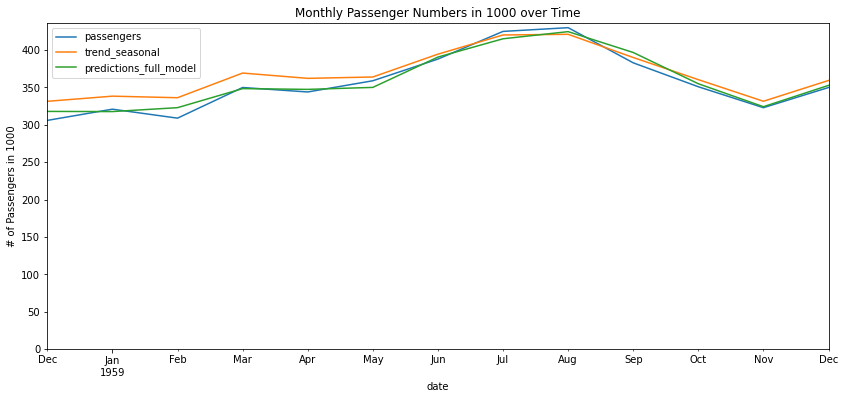

In [27]:
plot_flights(flights.loc['1958-12-01':'1959-12-01',['passengers', 'trend_seasonal', 'predictions_full_model']])

Coefficients of the AR equation's terms:

In [28]:
#m_full.coef_
m_full.intercept_

58.50338175923986

In [29]:
pd.DataFrame(m_full.coef_.reshape(1,13), columns=X_full.columns)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,2.322448,-3.263638,27.413914,18.000556,17.49629,45.719296,69.033211,67.619854,34.297405,2.338594,-28.892946,-3.397212,0.760241


---------------
---------------

This was what we did until this morning, exclusively with the training data. 

In [43]:
# To find mean percentage absolute value
import numpy as np
# MPAE
np.mean(np.abs(flights.predictions_full_model - flights.passengers)/ np.abs(flights.passengers)) * 100

# where,

error_deg_second_way = np.mean(np.abs(flights.predictions_full_model - flights.passengers)
# mean (absolute_difference(actual value - predicted value)/ actual value)
# gives a 3% error
# Find the error bar given for the predicted temperatures versus the test data
from sklearn.metrics import mean_absolute_error
error_deg = mean_absolute_error(flights.passengers,flights.predictions_full_model ) ;
print(f'The uncertainty of the predicted temperature for the range of the test data is \u00B1 {error_deg} passengers.')


The uncertainty of the predicted temperature for the range of the test data is ± 6.1141152887412495 passengers.


# Is this model good?

# 11) - Evaluate our model

We want to understand how good our model would work on data it has not been trained on. We can get an estimate of that by using cross-validation.

Cross-validation so far:



Cross-validation for time series:



In [30]:
X_full

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1949-02-01,1,1,0,0,0,0,0,0,0,0,0,0,4.405303
1949-03-01,2,0,1,0,0,0,0,0,0,0,0,0,17.496212
1949-04-01,3,0,0,1,0,0,0,0,0,0,0,0,7.496212
1949-05-01,4,0,0,0,1,0,0,0,0,0,0,0,9.587121
1949-06-01,5,0,0,0,0,1,0,0,0,0,0,0,-5.231061
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959-08-01,127,0,0,0,0,0,0,1,0,0,0,0,4.776515
1959-09-01,128,0,0,0,0,0,0,0,1,0,0,0,8.867424
1959-10-01,129,0,0,0,0,0,0,0,0,1,0,0,-7.132576


In [39]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [40]:
# Split the training data into folds   Illustration of the above split
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print('\n')
    

The training data for the 1th iteration are the observations steps 
    [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
The validation data for the 1th iteration are the observations steps
    [26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


The training data for the 2th iteration are the observations steps 
    [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
The validation data for the 2th iteration are the observations steps
    [47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]


The training data for the 3th iteration are the observations steps 
    [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
The validation data for the 3th iteration are the observations steps
  

In [41]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full) 

In [42]:
# Do the cross validation: Remember these are the 'test scores' in the training data.
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split,scoring='r2')
result

array([0.82727944, 0.82914029, 0.95730085, 0.9419188 , 0.92308191])

In [ ]:
# import sklearn
# sorted(sklearn.metrics)

In [35]:
result.mean()

0.8957442586519804

# 12) - Test your model

We finally use the test data. 

In [44]:
flights_test = pd.read_csv('data/flights_test.csv', index_col=0, parse_dates=True)
flights_test.head()

,passengers
date,
1960-01-01,357
1960-02-01,341
1960-03-01,358
1960-04-01,382
1960-05-01,388


In [45]:
flights_test

,passengers
date,
1960-01-01,357
1960-02-01,341
1960-03-01,358
1960-04-01,382
1960-05-01,388
1960-06-01,419
1960-07-01,458
1960-08-01,451
1960-09-01,406


First, the transformations necessary for the trend-seasonal model test: 

We will need to define the timestep using the last timestep of the training data (unless you split after adding the timestep and dummies). 

In [46]:
# Get last timestep of the training data
last_train_timestep = flights['timestep'][-1]

In [47]:
# Create a timestep for the whole test data
flights_test['timestep'] = list(range(last_train_timestep + 1, 
                            last_train_timestep + len(flights_test) + 1))
flights_test.head()

,passengers,timestep
date,,
1960-01-01,357,132
1960-02-01,341,133
1960-03-01,358,134
1960-04-01,382,135
1960-05-01,388,136


Now let's create the dummies for the seasonal component of the test.

In [48]:
seasonal_dummies = pd.get_dummies(flights_test.index.month, 
                                  prefix='month', 
                                  drop_first=True).set_index(flights_test.index)

flights_test = flights_test.join(seasonal_dummies)
flights_test.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,
1960-01-01,357,132,0,0,0,0,0,0,0,0,0,0,0
1960-02-01,341,133,1,0,0,0,0,0,0,0,0,0,0
1960-03-01,358,134,0,1,0,0,0,0,0,0,0,0,0
1960-04-01,382,135,0,0,1,0,0,0,0,0,0,0,0
1960-05-01,388,136,0,0,0,1,0,0,0,0,0,0,0


Let's select X and y.

In [49]:
X_test = flights_test.drop(columns=['passengers'])

In [50]:
X_test

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,
1960-01-01,132,0,0,0,0,0,0,0,0,0,0,0
1960-02-01,133,1,0,0,0,0,0,0,0,0,0,0
1960-03-01,134,0,1,0,0,0,0,0,0,0,0,0
1960-04-01,135,0,0,1,0,0,0,0,0,0,0,0
1960-05-01,136,0,0,0,1,0,0,0,0,0,0,0
1960-06-01,137,0,0,0,0,1,0,0,0,0,0,0
1960-07-01,138,0,0,0,0,0,1,0,0,0,0,0
1960-08-01,139,0,0,0,0,0,0,1,0,0,0,0
1960-09-01,140,0,0,0,0,0,0,0,1,0,0,0


Predict trend and seasonality for the test using **m** (which is trend_seasonal model for the training).

In [51]:
# since we do not have the y we have to predict it in order to find the trend seasonal
flights_test['trend_seasonal'] = m.predict(X_test)
flights_test.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
date,,,,,,,,,,,,,,
1960-01-01,357,132,0,0,0,0,0,0,0,0,0,0,0,366.286364
1960-02-01,341,133,1,0,0,0,0,0,0,0,0,0,0,364.195455
1960-03-01,358,134,0,1,0,0,0,0,0,0,0,0,0,397.195455
1960-04-01,382,135,0,0,1,0,0,0,0,0,0,0,0,390.104545
1960-05-01,388,136,0,0,0,1,0,0,0,0,0,0,0,391.922727


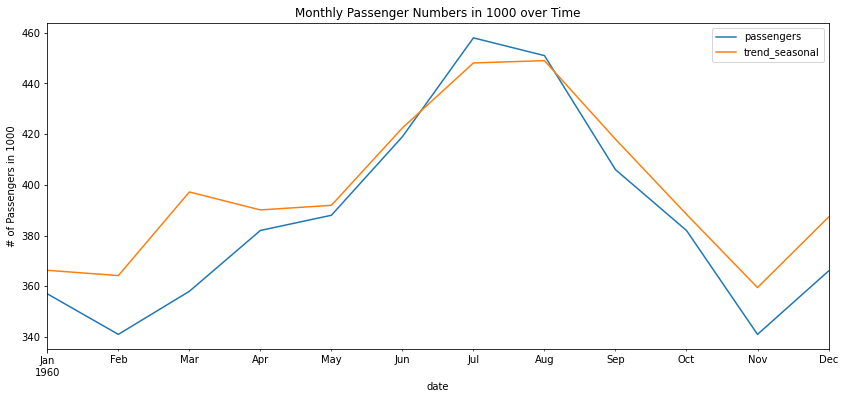

In [52]:
plot_flights(flights_test[['passengers', 'trend_seasonal']], ylim=False)

Calculate the remainder for the test set.

In [53]:
flights_test['remainder'] = flights_test['passengers'] - flights_test['trend_seasonal']


And finally the lag for the remainder as our additional feature for the AR model.

In [54]:
# Create the lagged variable
flights_test['lag1'] = flights_test['remainder'].shift(1)

In [55]:
# Assign X_full
X_full = flights_test.drop(columns=['passengers', 'trend_seasonal', 'remainder'])

In [56]:
X_full.head() # Contains a NaN for the first value of lag1

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1960-01-01,132,0,0,0,0,0,0,0,0,0,0,0,NaN
1960-02-01,133,1,0,0,0,0,0,0,0,0,0,0,-9.286364
1960-03-01,134,0,1,0,0,0,0,0,0,0,0,0,-23.195455
1960-04-01,135,0,0,1,0,0,0,0,0,0,0,0,-39.195455
1960-05-01,136,0,0,0,1,0,0,0,0,0,0,0,-8.104545


Filling in the missing value from the beginning of the test lag.

In [57]:
X_full.loc['1960-01-01', 'lag1'] = flights.loc['1959-12-01', 'remainder']

In [58]:
# Create the predictions
flights_test['predictions_full_model'] = m_full.predict(X_full)

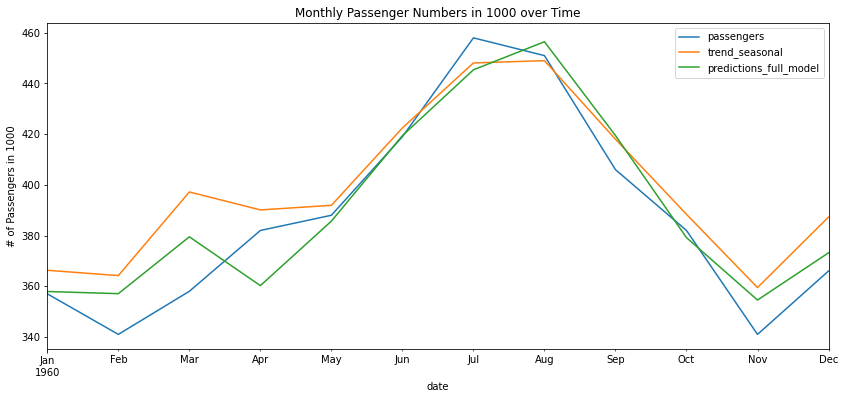

In [59]:
plot_flights(flights_test[['passengers', 'trend_seasonal', 'predictions_full_model']], ylim=False)

In [60]:
# Create the complete dataset and plot it
flights_full = flights[['passengers', 'trend_seasonal', 'predictions_full_model']].append(flights_test[['passengers', 'trend_seasonal', 'predictions_full_model']])

In [61]:
flights_full.head()

,passengers,trend_seasonal,predictions_full_model
date,,,
1949-02-01,75,57.503788,60.911282
1949-03-01,98,90.503788,103.863524
1949-04-01,93,83.412879,89.170208
1949-05-01,80,85.231061,92.577984
1949-06-01,103,115.776515,111.858054


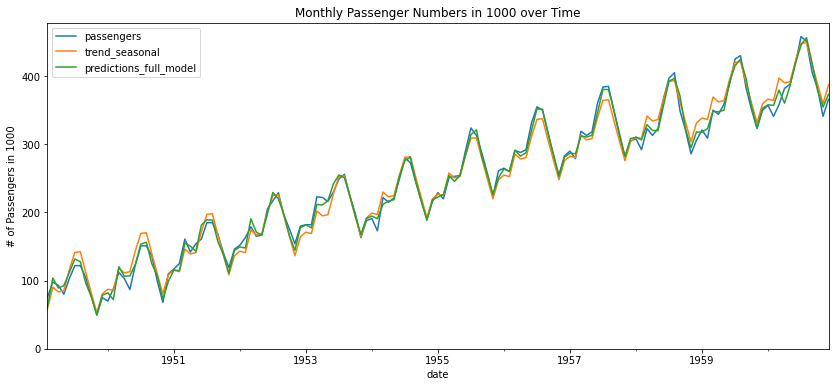

In [62]:
plot_flights(flights_full)

In [63]:
print(f"""
{m_full.score(X_full, flights_test['passengers'])}
{m.score(X_test, flights_test['passengers'])}
""")



0.8932731911942128
0.8036672855785687



In [64]:
X_full

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1960-01-01,132,0,0,0,0,0,0,0,0,0,0,0,-9.405303
1960-02-01,133,1,0,0,0,0,0,0,0,0,0,0,-9.286364
1960-03-01,134,0,1,0,0,0,0,0,0,0,0,0,-23.195455
1960-04-01,135,0,0,1,0,0,0,0,0,0,0,0,-39.195455
1960-05-01,136,0,0,0,1,0,0,0,0,0,0,0,-8.104545
1960-06-01,137,0,0,0,0,1,0,0,0,0,0,0,-3.922727
1960-07-01,138,0,0,0,0,0,1,0,0,0,0,0,-3.468182
1960-08-01,139,0,0,0,0,0,0,1,0,0,0,0,9.895455
1960-09-01,140,0,0,0,0,0,0,0,1,0,0,0,1.986364


In [65]:
flights_test

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
date,,,,,,,,,,,,,,,,,
1960-01-01,357,132,0,0,0,0,0,0,0,0,0,0,0,366.286364,-9.286364,NaN,357.916266
1960-02-01,341,133,1,0,0,0,0,0,0,0,0,0,0,364.195455,-23.195455,-9.286364,357.065499
1960-03-01,358,134,0,1,0,0,0,0,0,0,0,0,0,397.195455,-39.195455,-23.195455,379.491242
1960-04-01,382,135,0,0,1,0,0,0,0,0,0,0,0,390.104545,-8.104545,-39.195455,360.236483
1960-05-01,388,136,0,0,0,1,0,0,0,0,0,0,0,391.922727,-3.922727,-8.104545,385.691237
1960-06-01,419,137,0,0,0,0,1,0,0,0,0,0,0,422.468182,-3.468182,-3.922727,419.415880
1960-07-01,458,138,0,0,0,0,0,1,0,0,0,0,0,448.104545,9.895455,-3.468182,445.397808
1960-08-01,451,139,0,0,0,0,0,0,1,0,0,0,0,449.013636,1.986364,9.895455,456.466478
1960-09-01,406,140,0,0,0,0,0,0,0,1,0,0,0,418.013636,-12.013636,1.986364,419.453666


# 13) - Predict the future

So far we have just predicted data that we already had (train and test). We have not actually made any predictions for the future.

In [66]:
flights_test.head()

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
date,,,,,,,,,,,,,,,,,
1960-01-01,357,132,0,0,0,0,0,0,0,0,0,0,0,366.286364,-9.286364,NaN,357.916266
1960-02-01,341,133,1,0,0,0,0,0,0,0,0,0,0,364.195455,-23.195455,-9.286364,357.065499
1960-03-01,358,134,0,1,0,0,0,0,0,0,0,0,0,397.195455,-39.195455,-23.195455,379.491242
1960-04-01,382,135,0,0,1,0,0,0,0,0,0,0,0,390.104545,-8.104545,-39.195455,360.236483
1960-05-01,388,136,0,0,0,1,0,0,0,0,0,0,0,391.922727,-3.922727,-8.104545,385.691237


In [67]:
# Combine train and test data
flights_combined = flights.append(flights_test)
flights_combined

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
date,,,,,,,,,,,,,,,,,
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788,17.496212,4.405303,60.911282
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788,7.496212,17.496212,103.863524
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879,9.587121,7.496212,89.170208
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061,-5.231061,9.587121,92.577984
1949-06-01,103,5,0,0,0,0,1,0,0,0,0,0,0,115.776515,-12.776515,-5.231061,111.858054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08-01,451,139,0,0,0,0,0,0,1,0,0,0,0,449.013636,1.986364,9.895455,456.466478
1960-09-01,406,140,0,0,0,0,0,0,0,1,0,0,0,418.013636,-12.013636,1.986364,419.453666
1960-10-01,382,141,0,0,0,0,0,0,0,0,1,0,0,388.377273,-6.377273,-12.013636,379.173933


In [68]:
# Re-train the model on the whole dataset
X_combined = flights_combined.drop(columns=['passengers', 'trend_seasonal', 'remainder', 'predictions_full_model'])
y_combined = flights_combined['passengers']

In [69]:
flights_combined

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
date,,,,,,,,,,,,,,,,,
1949-02-01,75,1,1,0,0,0,0,0,0,0,0,0,0,57.503788,17.496212,4.405303,60.911282
1949-03-01,98,2,0,1,0,0,0,0,0,0,0,0,0,90.503788,7.496212,17.496212,103.863524
1949-04-01,93,3,0,0,1,0,0,0,0,0,0,0,0,83.412879,9.587121,7.496212,89.170208
1949-05-01,80,4,0,0,0,1,0,0,0,0,0,0,0,85.231061,-5.231061,9.587121,92.577984
1949-06-01,103,5,0,0,0,0,1,0,0,0,0,0,0,115.776515,-12.776515,-5.231061,111.858054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08-01,451,139,0,0,0,0,0,0,1,0,0,0,0,449.013636,1.986364,9.895455,456.466478
1960-09-01,406,140,0,0,0,0,0,0,0,1,0,0,0,418.013636,-12.013636,1.986364,419.453666
1960-10-01,382,141,0,0,0,0,0,0,0,0,1,0,0,388.377273,-6.377273,-12.013636,379.173933


In [70]:
X_combined

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1949-02-01,1,1,0,0,0,0,0,0,0,0,0,0,4.405303
1949-03-01,2,0,1,0,0,0,0,0,0,0,0,0,17.496212
1949-04-01,3,0,0,1,0,0,0,0,0,0,0,0,7.496212
1949-05-01,4,0,0,0,1,0,0,0,0,0,0,0,9.587121
1949-06-01,5,0,0,0,0,1,0,0,0,0,0,0,-5.231061
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08-01,139,0,0,0,0,0,0,1,0,0,0,0,9.895455
1960-09-01,140,0,0,0,0,0,0,0,1,0,0,0,1.986364
1960-10-01,141,0,0,0,0,0,0,0,0,1,0,0,-12.013636


Fill in the missing value from the beginning of the test set.

In [71]:
X_combined.loc['1960-01-01', 'lag1'] = flights.loc['1959-12-01', 'remainder']

In [72]:
X_combined.tail(1)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1960-12-01,143,0,0,0,0,0,0,0,0,0,0,1,-18.468182


In [73]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

### We are going to create a single future step data.

In [74]:
flights_combined.tail(1)

,passengers,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,predictions_full_model
date,,,,,,,,,,,,,,,,,
1960-12-01,366,143,0,0,0,0,0,0,0,0,0,0,1,387.286364,-21.286364,-18.468182,373.176016


In [75]:
# What is the first date in the future? --> 1961-01-01
timestep = flights_combined['timestep'].max() + 1
months = [0] * 11
lag = flights_combined.loc['1960-12-01', 'remainder']

In [76]:
timestep, months, lag

(144, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], -21.28636363636383)

In [77]:
X_future = [timestep]

X_future

[144]

In [78]:
X_future.extend(months)
X_future

[144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Check what would have happened above if you had used append instead of extend.

In [79]:
X_future.append(lag)
X_future

[144, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -21.28636363636383]

In [80]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,144,0,0,0,0,0,0,0,0,0,0,0,-21.286364


In [81]:
# Prediction for 1961-01-01
# m_full.predict(X_future) is somehow a better idea.
m_combined.predict(X_future)

array([376.10581815])

In [82]:
X_future.shape

(1, 13)

In [83]:
# How does this look like for 1961-02-01? So one more step to the future.
timestep = flights_combined['timestep'].max() + 2
months = [1] + [0]*10
lag = 0 
# This is too far in the future to calculate the lag.

In [84]:
X_future_2 = pd.DataFrame([[timestep] + months + [lag]])
X_future_2.columns = X_combined.columns
X_future_2

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,145,1,0,0,0,0,0,0,0,0,0,0,0


In [85]:
# Prediction for 1961-02-01

m_combined.predict(X_future_2)

array([389.79554877])

The prediction for 1961-02-01 was just the prediction of trend and seasonality.